<a href="https://colab.research.google.com/github/prakashradhakrish/Segmentation-using-UNet-Architecture/blob/master/Pedestrian_class_pennfudan_Group_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unet in PennFudan**#

---
#![alt text](https://drive.google.com/uc?id=1ou4XIG-yUOZUu_A7x66uduoXM-jqqQva)
---


# **Initialisation**

In [2]:
import numpy as np
import torch
import os
import re
import cv2
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as func
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from IPython.display import HTML, display
from torchvision import transforms,datasets,utils
%matplotlib inline
from torch.utils.data import DataLoader, TensorDataset


# **Dataset creation for pedestrian segmentation**

**List of steps for creating dataset**

*   Liniking the PennFudan train and test image from Google drive
*   Resizing the training images to 400x400 size and storing it in training data
*   Matching the target mask image to train data and resizing to 400x400 size 
*   Changing the target mask to train semantic segmentation  from the available instance segmentation mask



In [3]:
# Linking the google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Providing the directory for segregating train and mask image
datadir_trainimage = "/content/drive/My Drive/Dataset/PennFudanPed/train/PNGImages"
datadir_testimage = "/content/drive/My Drive/Dataset/PennFudanPed/train/PedMasks"

# training images
trainingdata=[] #empty array for saving training images as numpy array
trainingfile=[] #empty array for saving  corresponding training file names as numpy array
for img in os.listdir(datadir_trainimage):
    trainingfile.append(img)
    img_array =cv2.imread(os.path.join(datadir_trainimage,img),cv2.COLOR_RGB2GRAY)
    new_array = cv2.resize(img_array,(400,400))   
    trainingdata.append(np.squeeze([new_array]))

# masking images    
maskingdata=[] #empty array for saving target mask images as numpy array
maskingfile = [] #empty array for saving  corresponding target mask file names as numpy array
for i in range(len(trainingfile)):
    img = (trainingfile[i].rsplit('.png', 1)[0])+str("_mask.png")
    maskingfile.append(img)
    img_array =cv2.imread(os.path.join(datadir_testimage,img),cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(400,400))
    new_array[np.where(new_array>0.5)] = 1
    maskingdata.append(np.squeeze([new_array]))

#Converting into numpy which is easy to compute
trainingdata = np.array(trainingdata)
maskingdata = np.array(maskingdata)
    

*Checking the whether train and test images match with each other....*

In [5]:
mask_file = []
train_file = []
for i in range(len(maskingfile)):
  str_mask = re.findall('(.+)_mask',maskingfile[i])
  mask_file.append(str_mask)

for i in range(len(trainingfile)):
  str_mask = re.findall('(.+).png',trainingfile[i])
  train_file.append(str_mask)

if train_file == mask_file:
    print("status ok") 
else:
    print("mismatch found")

status ok


*Visualising the masking images.*

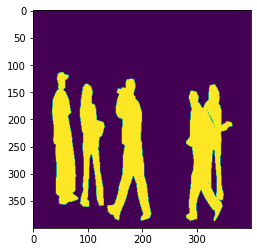

array([0, 1], dtype=uint8)

In [6]:
#plt.imshow(trainingdata[3])
plt.imshow(maskingdata[4])
plt.show()
np.unique(maskingdata[7])

**Images in numpy array to data loader pytorch**

In [7]:
# Dataset creation based on new data image

# RGB images obtained from CV2 has channel different than expected tensor
a = Tensor(trainingdata)
trainingdata_tensor = torch.empty(170,3,400,400,dtype=torch.float)
for i, img in enumerate(a):
    trainingdata_tensor[i,:,:,:] = img.permute(2,0,1)

# Converting to tensor dataset
dataset_created = TensorDataset(trainingdata_tensor, Tensor(maskingdata))
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(dataset_created, [150, 20])

batch_size = 5

# creating data loader for train and test
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
    'test': DataLoader(val_set, batch_size=1, shuffle=True, num_workers=2)
    }

# **Model creation**#

**Input size of image** : (3, 400, 400)

**Input type** : Tensor

**Output size of image** : (2, 400, 400) -> **Channel information:** pedestrian and background

**List of Unet models created for studies. Categorised based on parameters**

*   unet_5k - 5,938 parameters
*   unet_16k - 16,178 parameters
*   unet_50k - 48,018 parameters 
*   unet_78k - 78,802 parameters
*   unet_100k - 138000 parameters 
*   unet_3M - 3,873,986 parameters
*   unet_7M - 7,782,978 parameters

**5000 Parameters**

In [8]:
class unet_5k(nn.Module):
  def __init__(self):
    super(unet_5k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 8, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_2to1 = nn.ConvTranspose2d(16, 16, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(16+8, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)
    

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = torch.cat([self.upsampling_2to1(x3,output_size=x1.size()), x1], dim=1)
      x5 = self.explayer5(x4)
      x6 = self.output_conv(x5)
      return x6   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_5k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 400, 400]             224
              ReLU-2          [-1, 8, 400, 400]               0
         MaxPool2d-3          [-1, 8, 200, 200]               0
            Conv2d-4         [-1, 16, 200, 200]           1,168
              ReLU-5         [-1, 16, 200, 200]               0
   ConvTranspose2d-6         [-1, 16, 400, 400]           1,040
            Conv2d-7         [-1, 16, 400, 400]           3,472
              ReLU-8         [-1, 16, 400, 400]               0
            Conv2d-9          [-1, 2, 400, 400]              34
Total params: 5,938
Trainable params: 5,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.83
Forward/backward pass size (MB): 92.77
Params size (MB): 0.02
Estimated Total Size (MB): 94.63
---------------------------------------------

**16k Parameters**

In [9]:
class unet_16k(nn.Module):
  def __init__(self):
    super(unet_16k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)
    

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = torch.cat([self.upsampling_2to1(x3,output_size=x1.size()), x1], dim=1)
      x5 = self.explayer5(x4)
      x6 = self.output_conv(x5)
      return x6   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_16k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
              ReLU-5         [-1, 32, 200, 200]               0
   ConvTranspose2d-6         [-1, 32, 400, 400]           4,128
            Conv2d-7         [-1, 16, 400, 400]           6,928
              ReLU-8         [-1, 16, 400, 400]               0
            Conv2d-9          [-1, 2, 400, 400]              34
Total params: 16,178
Trainable params: 16,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.83
Forward/backward pass size (MB): 144.04
Params size (MB): 0.06
Estimated Total Size (MB): 145.94
-----------------------------------------

**50kParameters**

In [10]:
class unet_50k(nn.Module):
  def __init__(self):
    super(unet_50k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer4 = nn.Sequential(nn.Conv2d(32+32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

  def forward(self, x):
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_50k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
              ReLU-5         [-1, 32, 200, 200]               0
         MaxPool2d-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 32, 100, 100]           9,248
              ReLU-8         [-1, 32, 100, 100]               0
   ConvTranspose2d-9         [-1, 32, 200, 200]           4,128
           Conv2d-10         [-1, 32, 200, 200]          18,464
             ReLU-11         [-1, 32, 200, 200]               0
  ConvTranspose2d-12         [-1, 32, 400, 400]           4,128
           Conv2d-13         [-1, 16, 400, 400]           6,928
             ReLU-14         [-1, 16, 4

**78kParameters**

In [11]:
class unet_78k(nn.Module):
  def __init__(self):
    super(unet_78k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0)
    self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

  def forward(self, x):
      #x = x.view(-1, 128 * 128)
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_78k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
              ReLU-5         [-1, 32, 200, 200]               0
         MaxPool2d-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 64, 100, 100]          18,496
              ReLU-8         [-1, 64, 100, 100]               0
   ConvTranspose2d-9         [-1, 64, 200, 200]          16,448
           Conv2d-10         [-1, 32, 200, 200]          27,680
             ReLU-11         [-1, 32, 200, 200]               0
  ConvTranspose2d-12         [-1, 32, 400, 400]           4,128
           Conv2d-13         [-1, 16, 400, 400]           6,928
             ReLU-14         [-1, 16, 4

**100kParameters** - 0.01M

In [12]:
class unet_100k(nn.Module):
  def __init__(self):
    super(unet_100k,self).__init__()

    #Encoder
    self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())
    self.downsampling = nn.MaxPool2d(2)

    #Decoder
    self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0)
    self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
    self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
    self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
    self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

  def forward(self, x):
      x1 = self.contractinglayer1(x)
      x2 = self.downsampling(x1)
      x3 = self.contractinglayer2(x2)
      x4 = self.downsampling(x3)
      x5 = self.contractinglayer3(x4)
      x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
      x7 = self.explayer4(x6)
      x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
      x9 = self.explayer5(x8)
      x10 = self.output_conv(x9)
      return x10   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_100k()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
              ReLU-2         [-1, 16, 400, 400]               0
            Conv2d-3         [-1, 16, 400, 400]           2,320
              ReLU-4         [-1, 16, 400, 400]               0
         MaxPool2d-5         [-1, 16, 200, 200]               0
            Conv2d-6         [-1, 32, 200, 200]           4,640
              ReLU-7         [-1, 32, 200, 200]               0
            Conv2d-8         [-1, 32, 200, 200]           9,248
              ReLU-9         [-1, 32, 200, 200]               0
        MaxPool2d-10         [-1, 32, 100, 100]               0
           Conv2d-11         [-1, 64, 100, 100]          18,496
             ReLU-12         [-1, 64, 100, 100]               0
           Conv2d-13         [-1, 64, 100, 100]          36,928
             ReLU-14         [-1, 64, 1

**3 Million parameters**

In [13]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet_3M(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1,stride=1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_3M()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
         MaxPool2d-3         [-1, 64, 200, 200]               0
            Conv2d-4        [-1, 128, 200, 200]          73,856
              ReLU-5        [-1, 128, 200, 200]               0
         MaxPool2d-6        [-1, 128, 100, 100]               0
            Conv2d-7        [-1, 256, 100, 100]         295,168
              ReLU-8        [-1, 256, 100, 100]               0
         MaxPool2d-9          [-1, 256, 50, 50]               0
           Conv2d-10          [-1, 512, 50, 50]       1,180,160
             ReLU-11          [-1, 512, 50, 50]               0
         Upsample-12        [-1, 512, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]       1,769,728
             ReLU-14        [-1, 256, 1

**7 Million parameters**


In [14]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet_7M(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1,stride=1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_7M()
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

# **Information to be set**

Requires input from the user

In [15]:
picking_architecture = 6 #required user input to choose architecture from 0 to 6
n_class =2 # enter the number of class here
num_epochs =50 # enter number of epochs

unetslist = [unet_5k(),unet_16k(),unet_50k(),unet_78k(),unet_100k(),UNet_3M(),UNet_7M()] # to select the model to train
unetsavelist = ["unet_5k.pth","unet_16k.pth","unet_50k.pth","unet_78k.pth","unet_100k.pth","UNet_3M.pth","UNet_7M.pth"] # to save the model

**Function for splitting the masking labels to channel required for training**

In [16]:
def label_split(labels,targetimage,n_class):
  for i in range(n_class):
    if i==0:
      labels[:,0,:,:] = (targetimage== 0)==1
    else:
        labels[:,i,:,:] = (targetimage!= i)==0
  return labels


# **Loss function**

**Using Dice loss with BCE loss**

**Dice loss function**

In [17]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

**Combining Dice loss with Binary cross entropy loss**

In [18]:
from collections import defaultdict
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

def calc_loss(pred, target, bce_weight=0.5):
    bce = func.binary_cross_entropy_with_logits(pred, target).type(dtype)

    pred = torch.sigmoid(pred).type(dtype)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss

# **Optimizer**

In [19]:
unet = unetslist[picking_architecture]
print("Architecture choosen with parameters: " + str(sum(p.numel() for p in unet.parameters())))
gpu_available = torch.cuda.is_available() 
if gpu_available:
    unet = unet.cuda()
    
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, unet.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


Architecture choosen with parameters: 7782978


**Load the pretrained dataset here if available**

**Note:**

* Ensure the directory is correct to search the .pth file
* Ensure correct name for .pth file matching the choosen model architecture
* If architecture matched we will see: **All keys matched successfully**

In [ ]:
unet.load_state_dict(torch.load(os.path.join("/content/drive/My Drive/Dataset/cityscape_400x400/","UNet_7M_city.pth")))

<All keys matched successfully>

# **Training**

In [ ]:
loss_values =[]
running_loss = 0.0

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)


    scheduler.step()
    for param_group in optimizer.param_groups:
      print("LR", param_group['lr'])

    for i, data in enumerate(dataloaders['train']):
        inputimage, targetimage = data
        
        if gpu_available:
            inputimage = inputimage.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputimage)
        

        labels = torch.empty_like(outputs)
        lab_channel = (label_split(labels,targetimage,n_class)).cuda()


        loss = calc_loss(outputs,lab_channel)

        #loss += lmbd * reg_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 10 == 9:
            print('[%d, %5d] loss: %.10f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / 170)
            running_loss = 0.0


**Dont run the save command if the training is not performed**



In [ ]:
torch.save(unet.state_dict(), os.path.join("/content/drive/My Drive/Dataset/PennFudanPed/",unetsavelist[picking_architecture]))

# **Testing**

**Load the pretrained dataset here if available**

**Note:**

* Ensure the directory is correct to search the .pth file
* Ensure correct name for .pth file matching the choosen model architecture
* If architecture matched we will see: **All keys matched successfully**

In [20]:
unet.load_state_dict(torch.load(os.path.join("/content/drive/My Drive/Dataset/PennFudanPed/",unetsavelist[picking_architecture])))

<All keys matched successfully>

**IOU metrics**

In [21]:
def iou(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) 
    #print(intersection,union)
   
    loss = ((intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection + smooth))
    
    return loss.mean()

**Checking the IOU for our test set**

Change the Iou threshold if needed

In [22]:
iou_threshold = 0.6 # enter the threshold for IOU metrics
correct_prediction = 0
total_prediction = 0
for i, data in enumerate(dataloaders['test']):
    inputimage, targetimage = data
    
    if gpu_available:
        inputimage = inputimage.cuda() 
        

    prediction = unet(inputimage)
    prediction = torch.sigmoid(prediction)  
    
    labels = torch.empty_like(prediction)
    lab_channel = (label_split(labels,targetimage,n_class)).cuda()

    loss_raw = ((iou(prediction,lab_channel,1e-9)).cpu())
    
    total_prediction = total_prediction + 1
    if loss_raw > iou_threshold:
      correct_prediction = correct_prediction + 1

print("IOU loss: " + str(correct_prediction/total_prediction) +str(" for IOU threshold of: ") + str(iou_threshold))

IOU loss: 0.95 for IOU threshold of: 0.6


**Visualising the predicted output**

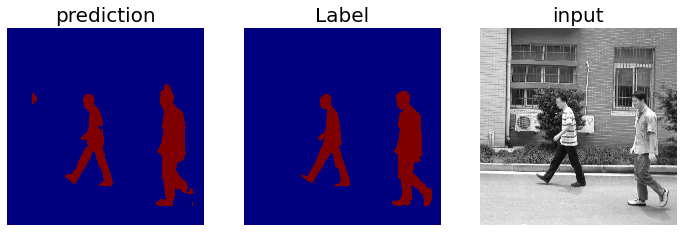

In [30]:
import math

# Get the first batch
inputs1, targetimage = next(iter(dataloaders['test']))
inputs = inputs1.cuda()

# Predict
pred = unet(inputs)

# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred_max = torch.argmax(pred, dim=1)


#printing image
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
ax1.imshow(pred_max.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax2.imshow(targetimage.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax3.imshow(inputs1[:,2,:,:].squeeze(0).cpu(),  interpolation='none',cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('prediction',fontsize=20)
ax2.set_title('Label',fontsize=20)
ax3.set_title('input',fontsize=20)
plt.show()
